In [ ]:
#!/usr/bin/env python
import multiprocessing as mp
import os
import pickle
from datetime import datetime

import pandas as pd
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from src.data import preprocess_data, embed_data

## 1. Data Preprocessing

In [ ]:
df_train, df_eval = preprocess_data()
df_train, df_eval = embed_data(df_train, df_eval)

X = df_train.drop(columns=['EventType', 'MatchID', 'PeriodID', 'ID']).values
y = df_train['EventType'].values

X_id = df_eval['ID'].values
X_eval = df_eval.drop(columns=['MatchID', 'PeriodID', 'ID']).values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

## 2. Model Training

In [ ]:
# For Kaggle submission save
def save_predictions_model(clf, params, accuracy):
    clf.fit(X, y)
    preds = clf.predict(X_eval)
    pred_df = pd.DataFrame({'ID': X_id, 'EventType': preds})
    # <clf name>/<params>/<filename>_predictions.csv
    params = params.replace(' ', '')
    today = datetime.today().strftime('%Y%m%d')
    file_folder = f"pred-{today}/{clf.__class__.__name__}-{accuracy}/{params}/"
    os.makedirs(file_folder, exist_ok=True)
    file_path = os.path.join(file_folder, f"{clf.__class__.__name__}_predictions.csv")
    pred_df.to_csv(file_path, index=False)
    print(f"Predictions saved to {file_path}")
    return file_folder


def test_clf(clf, params):
    y_pred = clf.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    print(f"{clf.__class__.__name__} Test set: ", accuracy_score(y_valid, y_pred), f"Params: {params}")
    # plot confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    return acc

### 2.1 Logistic Regression

LogisticRegression Test set:  0.7289719626168224 Params: {'C': 0.5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': 88, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 1e-08, 'verbose': 0, 'warm_start': False}


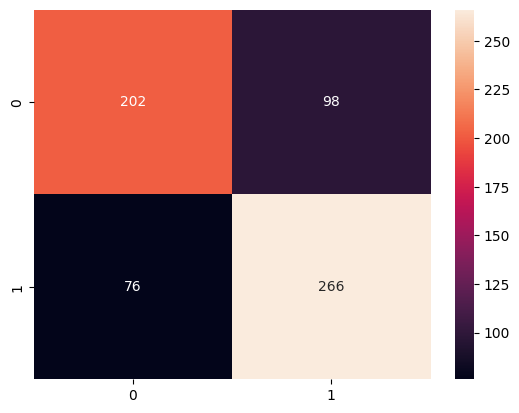

In [18]:
# Try on logistic regression
clf_log_reg = LogisticRegression(tol=1e-8, max_iter=1000, C=0.5, n_jobs=mp.cpu_count()).fit(X_train, y_train)
acc_log_reg = test_clf(clf_log_reg, LogisticRegression.get_params(clf_log_reg))

In [19]:
save_predictions_model(clf=clf_log_reg, params="tol=1e-8,max_iter=1000,C=0.5", accuracy=acc_log_reg)

Predictions saved to pred/LogisticRegression/tol=1e-8,max_iter=1000,C=0.5/LogisticRegression_predictions.csv


## 3.2 MLP

MLPClassifier Test set:  0.7819314641744548 Params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


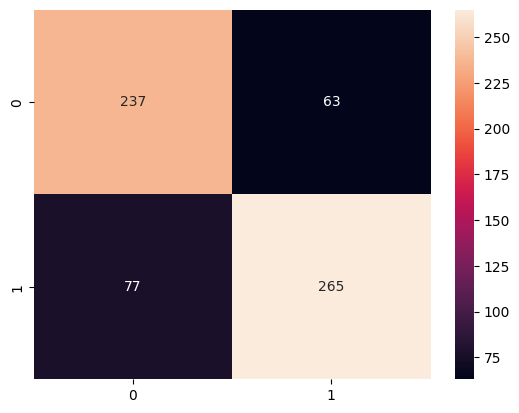

In [20]:
# MLP
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000).fit(X_train, y_train)
acc_mlp = test_clf(clf_mlp, MLPClassifier.get_params(clf_mlp))

In [21]:
save_predictions_model(clf=clf_mlp, params="hidden_layer_sizes=(100,), max_iter=1000, ", accuracy=acc_mlp)

Predictions saved to pred/MLPClassifier/hidden_layer_sizes=(100,), max_iter=1000, random_state=42/MLPClassifier_predictions.csv


## 3.3 Decision Tree

DecisionTreeClassifier Test set:  0.6697819314641744 Params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


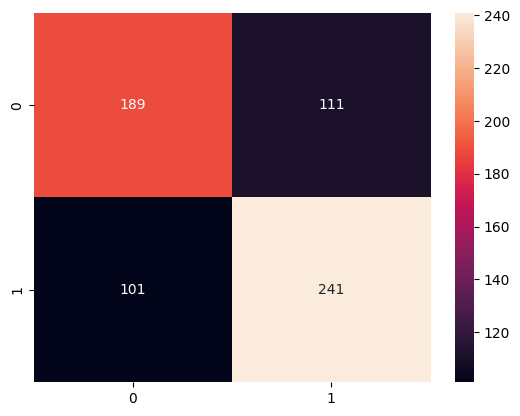

In [22]:
# dt
clf_dt = DecisionTreeClassifier().fit(X_train, y_train)
acc_dt = test_clf(clf_dt, DecisionTreeClassifier.get_params(clf_dt))

## 3.4 Random Forest

RandomForestClassifier Test set:  0.7850467289719626 Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': 88, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


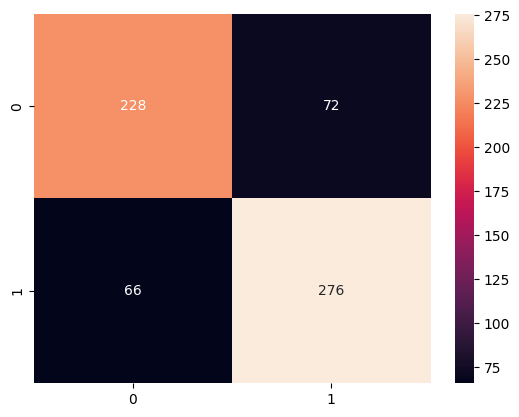

In [23]:
# Rand forest
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=mp.cpu_count()).fit(X_train, y_train)
acc_rf = test_clf(clf_rf, RandomForestClassifier.get_params(clf_rf))

In [24]:
save_predictions_model(clf=clf_dt, params="", accuracy=acc_dt)

Predictions saved to pred/DecisionTreeClassifier/random_state=42/DecisionTreeClassifier_predictions.csv


In [25]:
save_predictions_model(clf=clf_rf, params="n_estimators=100, , n_jobs=mp.cpu_count()", accuracy=acc_rf)

Predictions saved to pred/RandomForestClassifier/n_estimators=100, random_state=42, n_jobs=mp.cpu_count()/RandomForestClassifier_predictions.csv


## 3.5 Ensemble Methods

BaggingClassifier Test set:  0.764797507788162 Params: {'bootstrap': True, 'bootstrap_features': False, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': 88, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(n_jobs=88), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': 88, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


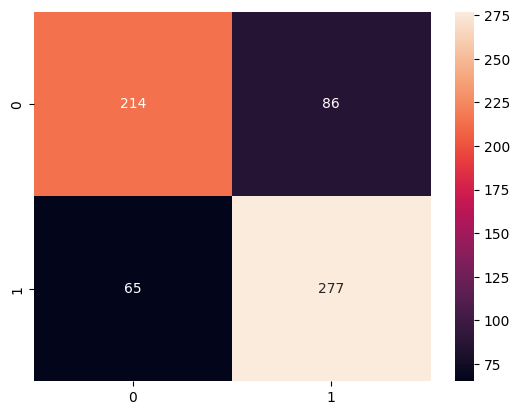

In [26]:
# Bagging
clf_bagging = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=100, n_jobs=mp.cpu_count()),
                                n_estimators=100, n_jobs=mp.cpu_count()).fit(X_train, y_train)
acc_bagging = test_clf(clf_bagging, BaggingClassifier.get_params(clf_bagging))

In [42]:
file_folder = save_predictions_model(clf=clf_bagging,
                                     params="estimator=RandomForestClassifier(n_estimators=100, n_jobs=mp.cpu_count()),n_estimators=100, n_jobs=mp.cpu_count()", accuracy=acc_bagging)
# save bagging model
with open(f"{file_folder}/bagging_model.pkl", 'wb') as f:
    pickle.dump(clf_bagging, f)

Predictions saved to pred-20241208/BaggingClassifier/estimator=MLPClassifier(),learning_rate='adaptive',max_iter=10000,random_state=42),n_estimators=100/BaggingClassifier_predictions.csv


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier Test set:  0.721183800623053 Params: {'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': 42}


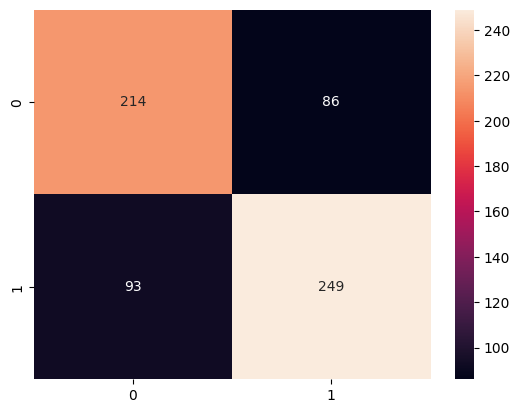

In [27]:
# AdaBoost
clf_adaboost = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)
acc_adaboost = test_clf(clf_adaboost, AdaBoostClassifier.get_params(clf_adaboost))

BaggingClassifier Test set:  0.778816199376947 Params: {'bootstrap': True, 'bootstrap_features': False, 'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__batch_size': 'auto', 'estimator__beta_1': 0.9, 'estimator__beta_2': 0.999, 'estimator__early_stopping': False, 'estimator__epsilon': 1e-08, 'estimator__hidden_layer_sizes': (100,), 'estimator__learning_rate': 'adaptive', 'estimator__learning_rate_init': 0.001, 'estimator__max_fun': 15000, 'estimator__max_iter': 10000, 'estimator__momentum': 0.9, 'estimator__n_iter_no_change': 10, 'estimator__nesterovs_momentum': True, 'estimator__power_t': 0.5, 'estimator__random_state': 42, 'estimator__shuffle': True, 'estimator__solver': 'adam', 'estimator__tol': 0.0001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': False, 'estimator__warm_start': False, 'estimator': MLPClassifier(learning_rate='adaptive', max_iter=10000, random_state=42), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': 8

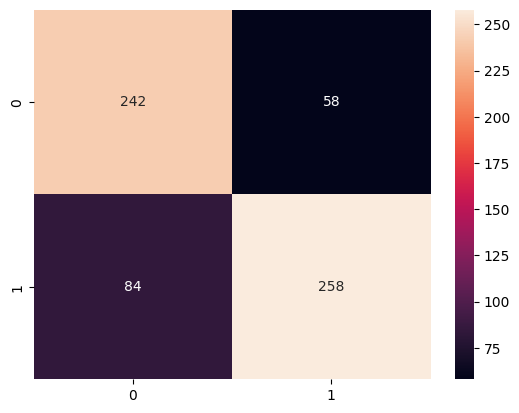

In [41]:
# Bagging with MLP
clf_bagging = BaggingClassifier(estimator=MLPClassifier(learning_rate='adaptive', max_iter=10000, random_state=42),
                                n_estimators=100, n_jobs=mp.cpu_count()).fit(X_train, y_train)
acc_bagging = test_clf(clf_bagging, BaggingClassifier.get_params(clf_bagging))

In [42]:
file_folder = save_predictions_model(clf=clf_bagging,
                                     params="estimator=MLPClassifier(),learning_rate='adaptive', max_iter=10000, random_state=42),n_estimators=100", accuracy=acc_bagging)
# save bagging model
with open(f"{file_folder}/bagging_model.pkl", 'wb') as f:
    pickle.dump(clf_bagging, f)

Predictions saved to pred-20241208/BaggingClassifier/estimator=MLPClassifier(),learning_rate='adaptive',max_iter=10000,random_state=42),n_estimators=100/BaggingClassifier_predictions.csv
